In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.optimize import minimize_scalar

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [85]:
# function to calculate A and B from the dataset
def OUanalytic1(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/2/A**2
    Btmp = (N-1)*(1+B**2)/(1-B**2)**2
    tmp = (2+6*B**2)*(data1sq+dataNsq) + (4+12*B**2)*datasq - (12*B+4*B**3)*datacorr
    P2B = Btmp - tmp/A/2/(1-B**2)**3
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult1(data,deltat):
    A, dA, B ,dB = OUanalytic1(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [86]:
# function to calculate A and B from the dataset
def OUanalytic2(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult2(data,deltat):
    A, dA, B ,dB = OUanalytic2(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [2]:
A,D = 1.0,1.0
delta_t_list=np.linspace(0.01,2,200)
#M=1000 # number of data sets
N=50000 # length of data set
#print(np.exp(-delta_t*D/A))

In [110]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

result_Bayes_array = None
for delta_t in delta_t_list:
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult1(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

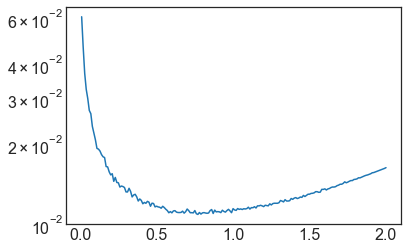

In [111]:
plt.semilogy(delta_t_list,result_Bayes_array.T[3])

In [101]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

result_Bayes_array2 = None
for delta_t in delta_t_list:
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult2(data,delta_t)
    if result_Bayes_array2 is None:
        result_Bayes_array2 = results
    else:
        result_Bayes_array2 = np.vstack((result_Bayes_array2, results))

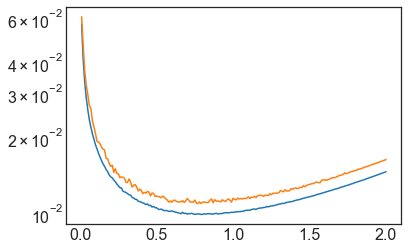

In [115]:
plt.semilogy(delta_t_list,4*result_Bayes_array2.T[3])
plt.semilogy(delta_t_list,result_Bayes_array.T[3])

In [106]:
def dt_tau(r):
    return np.exp(r)/r *np.sqrt((1-np.exp(-2*r)**3)/(2-np.exp(-2*r)*(1+np.exp(-2*r))))

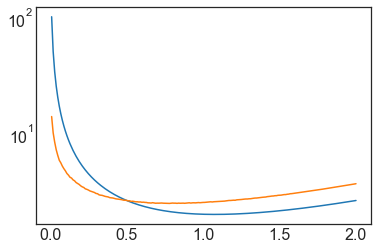

In [107]:
plt.semilogy(delta_t_list, dt_tau(delta_t_list))
plt.semilogy(delta_t_list,1000*result_Bayes_array.T[3])

In [33]:
minimize_scalar(dt_tau)

/Users/hstrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


     fun: 2.718281828459045
    nfev: 12
     nit: 8
 success: True
       x: 1.0

In [3]:
# function to calculate A and B from the dataset
def OUlargeN(N,A,B):
    data1sq = A
    dataNsq = A
    datasq = (N-2)*A
    datacorr = (N-1)*A*B
    P2A = -N/2/A**2
    Btmp = (N-1)*(1+B**2)/(1-B**2)**2
    tmp = (2+6*B**2)*(data1sq+dataNsq) + (4+12*B**2)*datasq - (12*B+4*B**3)*datacorr
    P2B = Btmp - tmp/A/2/(1-B**2)**3
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return dA,dB

def OUlargeN2(deltat,N,A,tau):
    dA,dB = OUlargeN(N,A,np.exp(-deltat/tau))
    dtau = np.exp(deltat/tau)*tau/deltat*dB
    return dA,dtau

In [14]:
dA,dtau = OUlargeN2(delta_t_list,10000,1,1)
dtau2,dA2 = OUlargeN2(delta_t_list,10000,2,1)

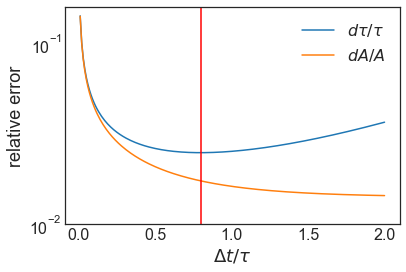

In [17]:
plt.semilogy(delta_t_list,dtau,label=r'$d\tau/\tau$')
plt.semilogy(delta_t_list,dA,label=r'$dA/A$')
plt.axvline(x=0.7968,color='r')
plt.yticks([1e-1,1e-2])
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel('relative error')
plt.legend()
plt.savefig("optimaldt.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [163]:
minimize_scalar(OUlargeN2,args=(1000000,1,1))

/Users/hstrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/hstrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/hstrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/hstrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


     fun: 0.0024852681215484815
    nfev: 22
     nit: 18
 success: True
       x: 0.7968114574265955

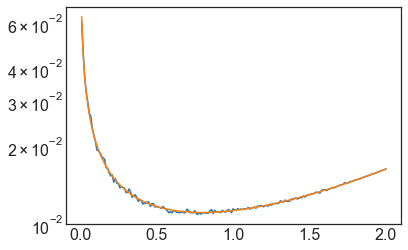

In [185]:
plt.semilogy(delta_t_list,result_Bayes_array.T[3])
plt.semilogy(delta_t_list,dtau)

In [156]:
np.log(0.797)

-0.22690060019192196

In [171]:
# how many samples per tau
1/0.227

4.405286343612334